The notebook uses references from the following notebooks

* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY</a>
* <a href="https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook">NLP with Disaster Tweets - EDA, Cleaning and BERT</a>
* <a href="https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings">How to: Preprocessing when using embeddings</a>

* <a href="https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook">NLP (Disaster Tweets) with Glove and LSTM</a>

# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.metrics import (precision_score, recall_score, accuracy_score,
                             f1_score, roc_auc_score, classification_report)
from sklearn.model_selection import train_test_split

from path import Path

from nltk.tokenize import word_tokenize

# LOADING DATASET

A cleaned datasset from <a href="https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook">NLP with Disaster Tweets - EDA, Cleaning and BERT</a>

In [2]:
path = Path("/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert")
train = pd.read_pickle(path / "train.pkl")
test = pd.read_pickle(path / "test.pkl")
sample_sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")


train.head()

,id,keyword,location,text,target,text_cleaned,target_relabeled
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,1


In [3]:
train['text_cleaned'] = train['text_cleaned'] .str.lower().map(lambda x: re.sub(' +', ' ', x))
test['text_cleaned']  = test['text_cleaned'].str.lower().map(lambda x: re.sub(' +', ' ', x))

****Loading glove embeddings****

In [4]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

# KERAS VERSION

In [5]:
import tensorflow as tf
from tensorflow import keras
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

2024-02-06 19:09:42.457379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 19:09:42.457476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 19:09:42.624598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
train_tweets = train['text_cleaned'].values
test_tweets = test['text_cleaned'].values
train_target = train['target'].values

In [7]:
# convert the text to lowercase, filter on puncuations, split on word_tokenize
word_tokenizer = Tokenizer(oov_token="<unk>")  
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1 # for by default padding at zero 
vocab_length
# in index 0 we have pad and in index 1 have unkown word

16937

In [8]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_tweets, key=lambda sentence: len(sentence.split()))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences.shape

(7613, 73)

In [9]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
counter = 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        counter+=1
        
embedding_matrix.shape

(16937, 100)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [11]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 73, 100)           1693700   
                                                                 
 bidirectional (Bidirection  (None, 73, 146)           101616    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 146)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 146)               584       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 146)               0         
                                                        

In [12]:
# Load the model and train!!
model = glove_lstm()
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/7


I0000 00:00:1707246604.483863     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 [==============================] - 79s 392ms/step - loss: 0.6319 - accuracy: 0.7033 - val_loss: 0.5729 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - 63s 350ms/step - loss: 0.5052 - accuracy: 0.7802 - val_loss: 0.4417 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 3/7
179/179 [==============================] - 62s 344ms/step - loss: 0.4478 - accuracy: 0.8091 - val_loss: 0.4591 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 4/7
179/179 [==============================] - 62s 345ms/step - loss: 0.4394 - accuracy: 0.8161 - val_loss: 0.4205 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 5/7
179/179 [==============================] - 62s 347ms/step - loss: 0.4138 - accuracy: 0.8240 - val_loss: 0.4155 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 6/7
179/179 [==============================] - 62s 348ms/step - loss: 0.3784 - accuracy: 0.8434 - val_loss: 0.4177 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 7/7
179/179 [==============================] - 62s 347ms/step 

In [13]:
pred_probs = model.predict(X_test)
preds = np.round(pred_probs)


print("-"*50 + "For keras:" + "-"*50)
print(classification_report(y_test, preds))

60/60 [==============================] - 3s 38ms/step
--------------------------------------------------For keras:--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1122
           1       0.79      0.79      0.79       782

    accuracy                           0.83      1904
   macro avg       0.82      0.82      0.82      1904
weighted avg       0.83      0.83      0.83      1904



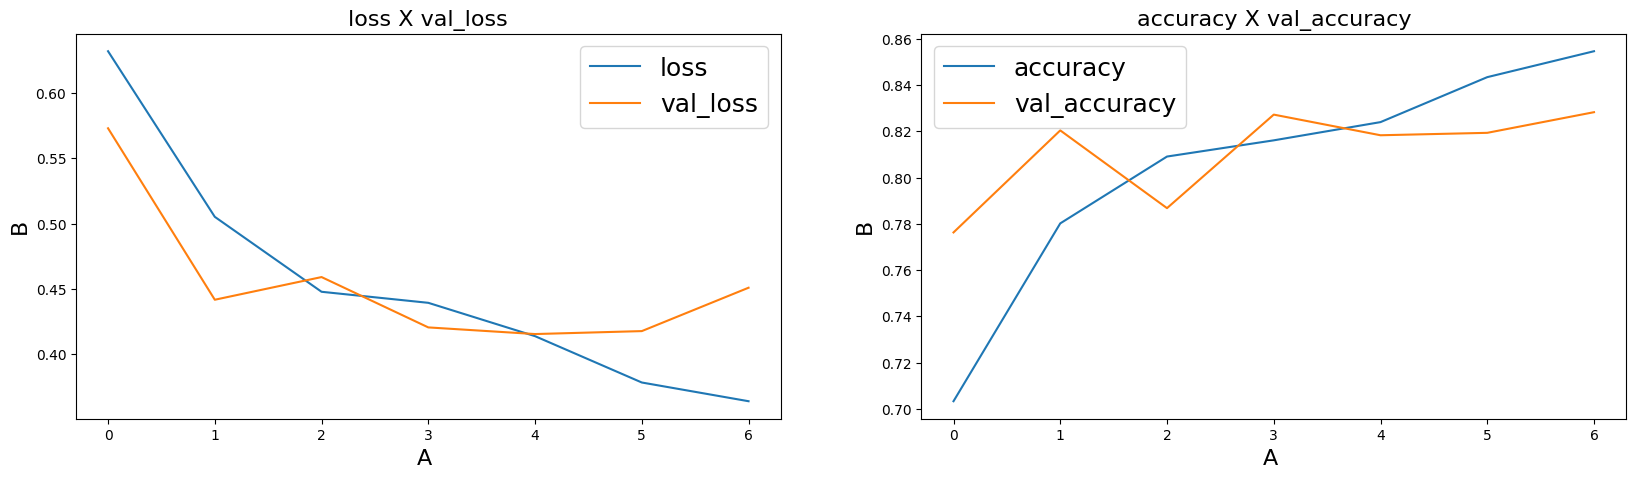

In [14]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history[arr[idx][0]])
        ax[idx].plot(history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history.history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

# IN PYTORCH

In [15]:
import torch
from torch import nn

In [16]:
from collections import Counter, OrderedDict
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab



tokenizer = get_tokenizer(None)  
corpus = train['text_cleaned'].tolist()


counter = Counter()
for tweet in corpus:
    tokens = [token.strip() for token in tokenizer(tweet) if token not in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']
    counter.update(tokens) 
    
ordered_dict = OrderedDict(counter)


vocabulary = vocab(ordered_dict, specials=['pad', '<unk>']) # 0 for pad and 1 for unk
vocabulary.set_default_index(vocabulary['<unk>'])
vocab_size = len(vocabulary)
print(f"Our vocabulary has {vocab_size} words")

Our vocabulary has 16941 words


In [17]:
sorted(vocabulary.get_stoi().items(), key=lambda x: x[1])[:5]

[('pad', 0), ('<unk>', 1), ('our', 2), ('deeds', 3), ('are', 4)]

In [18]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
counter = 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        counter+=1
        
embedding_matrix.shape

(16941, 100)

In [19]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional

class CFG:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = 32
    TRAIN_SIZE = 0.8
    EMBEDDING_DIM = embedding_dim
    VOCAB_SIZE = vocab_size
    EMBEDDING_MATRIX = embedding_matrix
    MAX_WORD_COUNT = length_long_sentence

In [20]:
class DisasterTweetTrainDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer=tokenizer, vocabulary=vocabulary):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary
    
        
    def preprocess_text(self, text):
        tokens = [token.strip() for token in self.tokenizer(text) if token not in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']
        return self.vocabulary(tokens)
    
    def __len__(self):
        return len(self.labels)
    
    
    def get_text(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        return text, label
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        preprocessed_text = torch.tensor(self.preprocess_text(text), dtype=torch.int64)
        padded_text = functional.pad(preprocessed_text, (0, CFG.MAX_WORD_COUNT - len(preprocessed_text)), value=0)
        
        return padded_text, label
        
        
train_df = train.sample(frac=1, random_state=42)      
train_dataset = DisasterTweetTrainDataset(train_df['text_cleaned'].values, train['target'].values)

In [21]:
# def collate_batch(batch):
#     """
#         This collate function gets called after a batch has been created and before it gets passed to the model
#     """
#     text_list, label_list = [], []
#     for _text, _label, in batch:
#         label_list.append(_label)
#         text_list.append(_text)
        
#     label_list = torch.tensor(label_list, dtype=torch.float32)
#     text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    
#     return text_list.to(CFG.DEVICE), label_list.to(CFG.DEVICE)

In [22]:
split_train, split_valid = random_split(train_dataset, [CFG.TRAIN_SIZE, (1-CFG.TRAIN_SIZE)])

train_dataloader = DataLoader(split_train, batch_size=CFG.BATCH_SIZE, shuffle=True, pin_memory=True)

valid_dataloader = DataLoader(split_valid, batch_size=CFG.BATCH_SIZE, shuffle=True, pin_memory=True)

In [23]:
class TextClassificationModel1(nn.Module):
    def __init__(self, embedding_matrix, vocab_size, embed_dim, num_classes=1):
        super(TextClassificationModel1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=length_long_sentence, bidirectional=True, 
                            batch_first=True, num_layers=1)
        
        self.batchnorm = nn.BatchNorm1d(length_long_sentence*2)
        
        
        self.fc1 = nn.Linear(length_long_sentence*2, length_long_sentence)
        self.fc2 = nn.Linear(length_long_sentence, length_long_sentence)
        self.fc3 = nn.Linear(length_long_sentence, 1)
        
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
        self.init_weights(embedding_matrix)
#         
    def init_weights(self, embedding_matrix):
        self.embedding.weight.data = torch.tensor(embedding_matrix, dtype=torch.float32).clone() 
        
    def forward(self, text):
        out = self.embedding(text)
        out, (h_n, c_n) = self.lstm(out)
        
        out = torch.max(out, axis=1)[0]
        out = self.batchnorm(out)
        
        out = self.dropout1(out)
        out = functional.relu(self.fc1(out))
        out = self.dropout2(out)
        out = functional.relu(self.fc2(out))
        out = self.dropout3(out)
        
        out = self.fc3(out)
        out = self.sigmoid(out)
        
        return out

# FUNCTIONS TO TRAIN AND EVALUATE THE MODEL

In [24]:
from tqdm.notebook import tqdm

In [25]:
def model_train(dataloader, log_interval=32):
    model.train(True)
    log_interval = log_interval
    total_loss = 0
    total_score = 0
    total_count = 0
    
    pbar = tqdm(dataloader)
    for idx, (texts, labels) in enumerate(pbar):
        texts = texts.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        
        optimizer.zero_grad()
        predicted_probs = model(texts).flatten()
        
        loss = loss_fn(predicted_probs, labels.float())
        loss.backward()   
        
        optimizer.step()

        
        preds = predicted_probs.cpu().detach().numpy().round()
        score  = accuracy_score(labels.cpu().numpy(), preds)
          
            
        total_loss += loss.item()
        total_score += score
        total_count += 1
   

    return total_loss/total_count, total_score / total_count
            
def model_evaluate(dataloader):
    model.eval()
    total_loss, total_score, total_count = 0, 0, 0

    with torch.no_grad():
        for idx, (texts, labels) in enumerate(dataloader):
            texts = texts.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            predicted_probs = model(texts).flatten()
            loss = loss_fn(predicted_probs, labels.float())

            preds = predicted_probs.cpu().detach().numpy().round()
            score  = accuracy_score(labels.cpu().numpy(), preds)
          
            
            total_loss += loss.item()
            total_score += score
            total_count += 1
   
                      
    return total_loss/total_count, total_score/total_count


def model_predict(dataloader):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for idx, (texts, labels) in enumerate(tqdm(dataloader)):
            texts = texts.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            predicted_probs = model(texts).flatten()

            preds = predicted_probs.cpu().detach().numpy().round()
            
            predictions.append(preds)
            ground_truths.append(labels.cpu().numpy())
            
            
    return  np.concatenate(ground_truths), np.concatenate(predictions)

In [26]:
import time

model = TextClassificationModel1(CFG.EMBEDDING_MATRIX, CFG.VOCAB_SIZE, CFG.EMBEDDING_DIM, 1).to(CFG.DEVICE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
epochs = 50

history = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': []}

for epoch in range(1, epochs+1):
    start_time = time.time()
    
    train_loss, train_score = model_train(train_dataloader, CFG.BATCH_SIZE)
    valid_loss, valid_score = model_evaluate(valid_dataloader)
    
    end_time = time.time()
    print("-" * 100)
    print(
        "| End of epoch {:d} | time: {:.2f}s | train_loss: {:.4f} | valid_loss: {:.4f}"
        "| train accuracy {:.4f} | valid accuracy {:4f}".format(epoch, 
                                                                 end_time-start_time,
                                                                 train_loss, valid_loss,
                                                                 train_score, valid_score
                                                               )
    )
    
    print("-" * 100)
    
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_accuracy'].append(train_score)
    history['valid_accuracy'].append(valid_score)

  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 1 | time: 2.66s | train_loss: 0.6903 | valid_loss: 0.6884| train accuracy 0.5558 | valid accuracy 0.555845
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 2 | time: 1.36s | train_loss: 0.6828 | valid_loss: 0.6887| train accuracy 0.5662 | valid accuracy 0.557147
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 3 | time: 1.38s | train_loss: 0.6779 | valid_loss: 0.6889| train accuracy 0.5738 | valid accuracy 0.556062
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 4 | time: 1.38s | train_loss: 0.6676 | valid_loss: 0.6952| train accuracy 0.5956 | valid accuracy 0.539931
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 5 | time: 1.34s | train_loss: 0.6508 | valid_loss: 0.7014| train accuracy 0.6242 | valid accuracy 0.555483
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 6 | time: 1.38s | train_loss: 0.6201 | valid_loss: 0.7219| train accuracy 0.6618 | valid accuracy 0.546730
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 7 | time: 1.38s | train_loss: 0.5790 | valid_loss: 0.7791| train accuracy 0.7026 | valid accuracy 0.542969
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 8 | time: 1.34s | train_loss: 0.5213 | valid_loss: 0.7946| train accuracy 0.7449 | valid accuracy 0.520544
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 9 | time: 1.34s | train_loss: 0.4698 | valid_loss: 0.8876| train accuracy 0.7806 | valid accuracy 0.539641
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 10 | time: 1.34s | train_loss: 0.4118 | valid_loss: 0.9735| train accuracy 0.8168 | valid accuracy 0.526186
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 11 | time: 1.33s | train_loss: 0.3578 | valid_loss: 1.0687| train accuracy 0.8464 | valid accuracy 0.552590
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 12 | time: 1.37s | train_loss: 0.3303 | valid_loss: 1.0597| train accuracy 0.8611 | valid accuracy 0.530599
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 13 | time: 1.49s | train_loss: 0.2887 | valid_loss: 1.2242| train accuracy 0.8815 | valid accuracy 0.496600
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 14 | time: 1.39s | train_loss: 0.2697 | valid_loss: 1.1829| train accuracy 0.8860 | valid accuracy 0.513021
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 15 | time: 1.39s | train_loss: 0.2395 | valid_loss: 1.3338| train accuracy 0.9025 | valid accuracy 0.493417
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 16 | time: 1.34s | train_loss: 0.2221 | valid_loss: 1.4592| train accuracy 0.9072 | valid accuracy 0.517578
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 17 | time: 1.35s | train_loss: 0.2034 | valid_loss: 1.7382| train accuracy 0.9121 | valid accuracy 0.531901
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 18 | time: 1.35s | train_loss: 0.1949 | valid_loss: 1.7045| train accuracy 0.9179 | valid accuracy 0.520978
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 19 | time: 1.34s | train_loss: 0.1891 | valid_loss: 1.6130| train accuracy 0.9166 | valid accuracy 0.514829
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 20 | time: 1.35s | train_loss: 0.1763 | valid_loss: 1.7898| train accuracy 0.9239 | valid accuracy 0.527995
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 21 | time: 1.36s | train_loss: 0.1581 | valid_loss: 1.9067| train accuracy 0.9313 | valid accuracy 0.523727
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 22 | time: 1.36s | train_loss: 0.1575 | valid_loss: 2.2999| train accuracy 0.9277 | valid accuracy 0.509766
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 23 | time: 1.41s | train_loss: 0.1506 | valid_loss: 2.1110| train accuracy 0.9288 | valid accuracy 0.518374
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 24 | time: 1.34s | train_loss: 0.1445 | valid_loss: 1.9692| train accuracy 0.9315 | valid accuracy 0.529152
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 25 | time: 1.32s | train_loss: 0.1368 | valid_loss: 2.1434| train accuracy 0.9378 | valid accuracy 0.534867
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 26 | time: 1.37s | train_loss: 0.1295 | valid_loss: 2.8610| train accuracy 0.9362 | valid accuracy 0.510127
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 27 | time: 1.39s | train_loss: 0.1440 | valid_loss: 2.6627| train accuracy 0.9372 | valid accuracy 0.543692
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 28 | time: 1.38s | train_loss: 0.1336 | valid_loss: 2.6583| train accuracy 0.9368 | valid accuracy 0.523003
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 29 | time: 1.37s | train_loss: 0.1256 | valid_loss: 3.6258| train accuracy 0.9395 | valid accuracy 0.506076
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 30 | time: 1.35s | train_loss: 0.1312 | valid_loss: 8.9045| train accuracy 0.9408 | valid accuracy 0.469546
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 31 | time: 1.34s | train_loss: 0.1324 | valid_loss: 2.7360| train accuracy 0.9360 | valid accuracy 0.498409
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 32 | time: 1.36s | train_loss: 0.1172 | valid_loss: 2.9690| train accuracy 0.9424 | valid accuracy 0.514540
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 33 | time: 1.37s | train_loss: 0.1186 | valid_loss: 3.2174| train accuracy 0.9427 | valid accuracy 0.516131
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 34 | time: 1.35s | train_loss: 0.1291 | valid_loss: 2.6111| train accuracy 0.9426 | valid accuracy 0.542969
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 35 | time: 1.34s | train_loss: 0.1127 | valid_loss: 2.9287| train accuracy 0.9434 | valid accuracy 0.519893
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 36 | time: 1.38s | train_loss: 0.1115 | valid_loss: 3.5111| train accuracy 0.9426 | valid accuracy 0.521629
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 37 | time: 1.40s | train_loss: 0.1234 | valid_loss: 3.6040| train accuracy 0.9426 | valid accuracy 0.525246
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 38 | time: 1.36s | train_loss: 0.1110 | valid_loss: 4.0741| train accuracy 0.9449 | valid accuracy 0.515625
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 39 | time: 1.33s | train_loss: 0.1099 | valid_loss: 3.8467| train accuracy 0.9410 | valid accuracy 0.540726
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 40 | time: 1.35s | train_loss: 0.1210 | valid_loss: 2.4899| train accuracy 0.9387 | valid accuracy 0.523655
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 41 | time: 1.35s | train_loss: 0.1125 | valid_loss: 4.1661| train accuracy 0.9456 | valid accuracy 0.552951
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 42 | time: 1.37s | train_loss: 0.1111 | valid_loss: 2.9295| train accuracy 0.9446 | valid accuracy 0.521195
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 43 | time: 1.41s | train_loss: 0.1046 | valid_loss: 3.0401| train accuracy 0.9465 | valid accuracy 0.516638
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 44 | time: 1.37s | train_loss: 0.1058 | valid_loss: 3.8920| train accuracy 0.9499 | valid accuracy 0.526042
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 45 | time: 1.35s | train_loss: 0.1074 | valid_loss: 3.1503| train accuracy 0.9475 | valid accuracy 0.515408
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 46 | time: 1.40s | train_loss: 0.1076 | valid_loss: 3.5039| train accuracy 0.9473 | valid accuracy 0.515770
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 47 | time: 1.34s | train_loss: 0.1027 | valid_loss: 3.9403| train accuracy 0.9481 | valid accuracy 0.512080
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 48 | time: 1.35s | train_loss: 0.1074 | valid_loss: 5.8858| train accuracy 0.9455 | valid accuracy 0.512225
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 49 | time: 1.34s | train_loss: 0.1057 | valid_loss: 4.4568| train accuracy 0.9516 | valid accuracy 0.525897
----------------------------------------------------------------------------------------------------


  0%|          | 0/191 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 50 | time: 1.37s | train_loss: 0.1185 | valid_loss: 3.2511| train accuracy 0.9480 | valid accuracy 0.532190
----------------------------------------------------------------------------------------------------


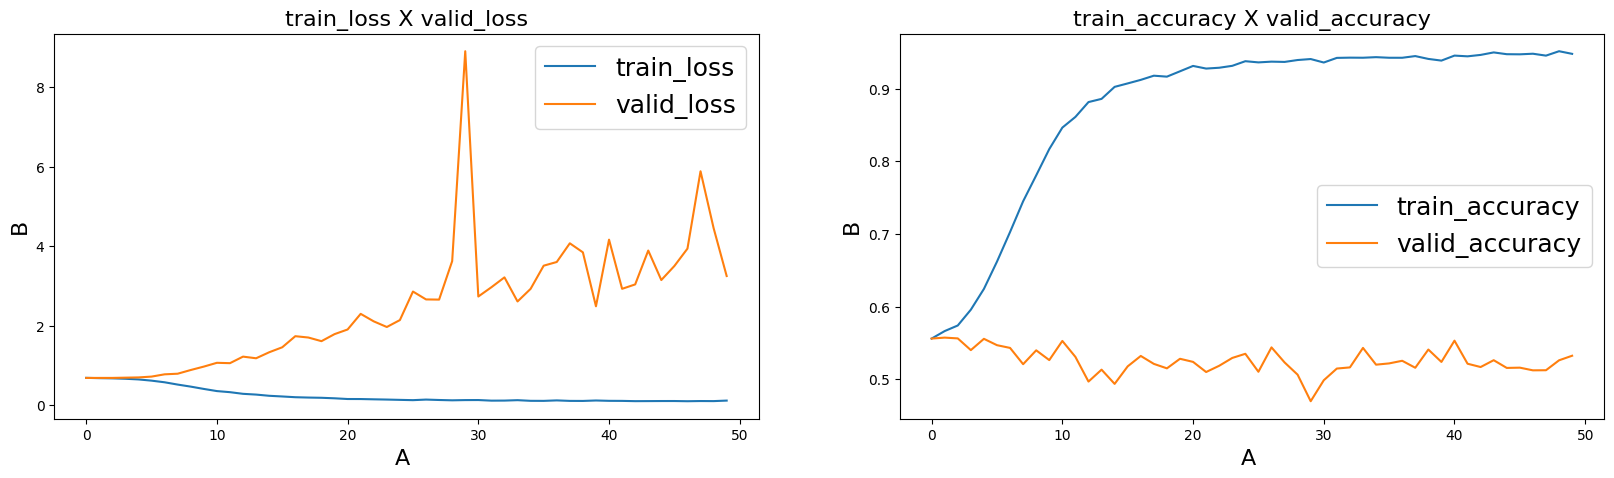

In [27]:
plot_learning_curves(history, [['train_loss', 'valid_loss'],['train_accuracy', 'valid_accuracy']])

In [28]:
labels, preds = model_predict(valid_dataloader)

print("For pytorh")
print(classification_report(labels, preds))

  0%|          | 0/48 [00:00<?, ?it/s]

For pytorh
              precision    recall  f1-score   support

           0       0.57      0.70      0.62       846
           1       0.46      0.33      0.38       676

    accuracy                           0.53      1522
   macro avg       0.51      0.51      0.50      1522
weighted avg       0.52      0.53      0.52      1522

